## **0. Introduction**

The problem statement here that given some `meta-data` about a recipie (eg: Instructions, cooking time, etc) can we predict what kind of course that may be (eg: Dinner, Side Dish, etc), total 7 different classes.

In this kernel we will go thorugh **data analysis**, **feature engineering ideas**, **cleaning and text processing**, **baselining classical ML models (SVM, xgboost) as well as diffeernt BERT models**.

Feel free to add any comment.


## NOTE: 
The `TranslatedInstructions` column in the original dataset had both hindi as well as english text. So my frist step to preprocessing was to translate that column into english with the help of gcloud translate. The link of the script is [here](https://github.com/Ascensiony/gcloud-translate-hi-to-en-swiggy)

## **1. Installations & Imports**

In [1]:
!pip install gensim --quiet
!pip install contractions --quiet
!pip install num2words --quiet
!pip install transformers==2.5.1 --quiet --no-dependencies
!pip install fastai==1.0.58 --quiet --no-dependencies

In [2]:
import re

import numpy as np
import pandas as pd

import string
import random
import unidecode
from collections import defaultdict
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

from gensim.models import Word2Vec

import contractions
from num2words import num2words

from tqdm import tqdm
# from pathlib import Path

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import xgboost as xgb

import torch
import torch.optim as optim

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    RobertaConfig,
)
from transformers import AdamW

import warnings
warnings.filterwarnings("ignore")

## **2. Loading Data**

Before we do anything lets seed everything, so that the output is deterministic.

In [3]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
seed = 42
seed_all(seed)

In [5]:
train_df = pd.read_csv("../input/translated-hi-to-en-6000-recipes-dataset/train_translated.csv")
test_df = pd.read_csv("../input/translated-hi-to-en-6000-recipes-dataset/test_translated.csv")

In [6]:
print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (4038, 8)
Training Set Memory Usage = 0.25 MB
Test Set Shape = (1990, 8)
Test Set Memory Usage = 0.12 MB


## **3. Analysis and Feature Engineering**

### **3.1 Cardinalty and Target Distribution**

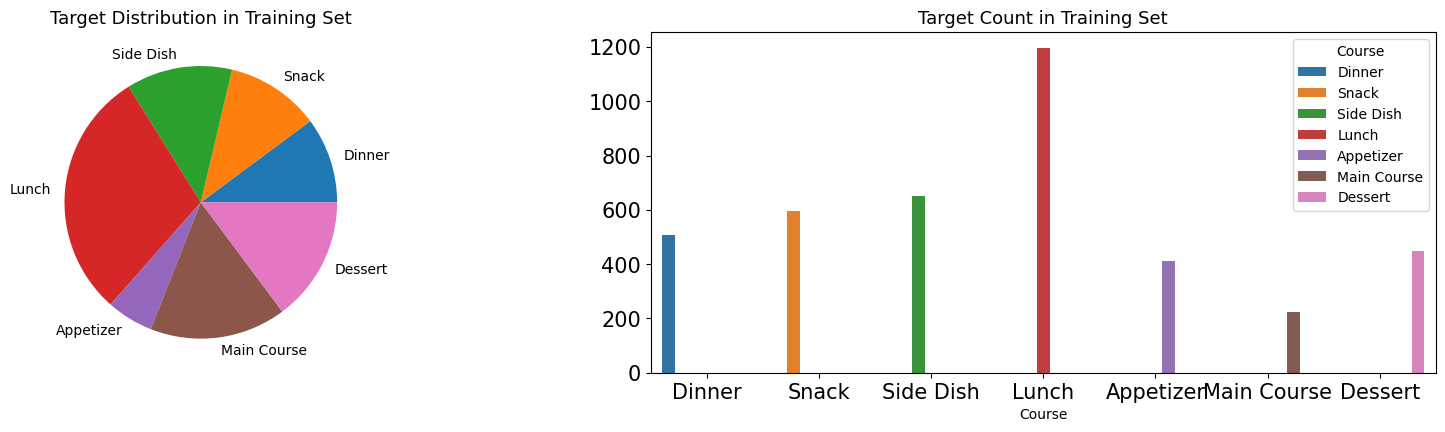

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_df.groupby("Course").count()["TranslatedIngredients"].plot(
    kind="pie",
    ax=axes[0],
    labels=[
        "Dinner",
        "Snack",
        "Side Dish",
        "Lunch",
        "Appetizer",
        "Main Course",
        "Dessert",
    ],
)

sns.countplot(x=train_df["Course"], hue=train_df["Course"], ax=axes[1])

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[1].set_xticklabels(
    ["Dinner", "Snack", "Side Dish", "Lunch", "Appetizer", "Main Course", "Dessert"]
)
axes[0].tick_params(axis="x", labelsize=15)
axes[0].tick_params(axis="y", labelsize=15)
axes[1].tick_params(axis="x", labelsize=15)
axes[1].tick_params(axis="y", labelsize=15)

axes[0].set_title("Target Distribution in Training Set", fontsize=13)
axes[1].set_title("Target Count in Training Set", fontsize=13)

plt.show()

### **3.2 Missing Values**
Both training and test set have some ratio of missing values in `TranslatedIngredients`.
* **3 data points** in `TranslatedIngredients` is missing in training
* **2 data points** in `TranslatedIngredients` is missing in test set

Missing values in those features are filled with `no_TranslatedIngredients`

In [8]:
# Let's check out the missing values with the .info() method
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038 entries, 0 to 4037
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TranslatedRecipeName    4038 non-null   object
 1   TranslatedIngredients   4035 non-null   object
 2   PrepTimeInMins          4038 non-null   int64 
 3   CookTimeInMins          4038 non-null   int64 
 4   TotalTimeInMins         4038 non-null   int64 
 5   Servings                4038 non-null   int64 
 6   Course                  4038 non-null   object
 7   TranslatedInstructions  4038 non-null   object
dtypes: int64(4), object(4)
memory usage: 252.5+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TranslatedRecipeName    1990 non-null   object
 1   TranslatedIngredients   1988 non-null   object
 2   PrepTimeInMins          1990 non-null   int64 
 3   CookTimeInMins          1990 non-null   int64 
 4   TotalTimeInMins         1990 non-null   int64 
 5   Servings                1990 non-null   int64 
 6   Course                  1990 non-null   object
 7   TranslatedInstructions  1990 non-null   object
dtypes: int64(4), object(4)
memory usage: 124.5+ KB


In [10]:
for df in [train_df, test_df]:
    for col in ['TranslatedIngredients']:
        df[col] = df[col].fillna(f'no_{col}')

### **3.3 Feature Engineering**

In [11]:
DINNER = train_df['Course'] == "Dinner"
SNACK = train_df['Course'] == "Snack"
SIDEDISH = train_df['Course'] == "Side Dish"
LUNCH = train_df['Course'] == "Lunch"
APPETIZER = train_df['Course'] == "Appetizer"
MAINCOURSE = train_df['Course'] == "Main Course"
DESSERT = train_df['Course'] == "Dessert"

#### Meta Features

Distributions of meta features in classes and datasets can be helpful to identify what type of `Course` it is.

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text

In [12]:
# word_count
train_df['word_count'] = train_df['TranslatedInstructions'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['TranslatedInstructions'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['TranslatedInstructions'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['TranslatedInstructions'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['TranslatedInstructions'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['TranslatedInstructions'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
train_df['mean_word_length'] = train_df['TranslatedInstructions'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['TranslatedInstructions'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['TranslatedInstructions'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['TranslatedInstructions'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['TranslatedInstructions'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['TranslatedInstructions'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

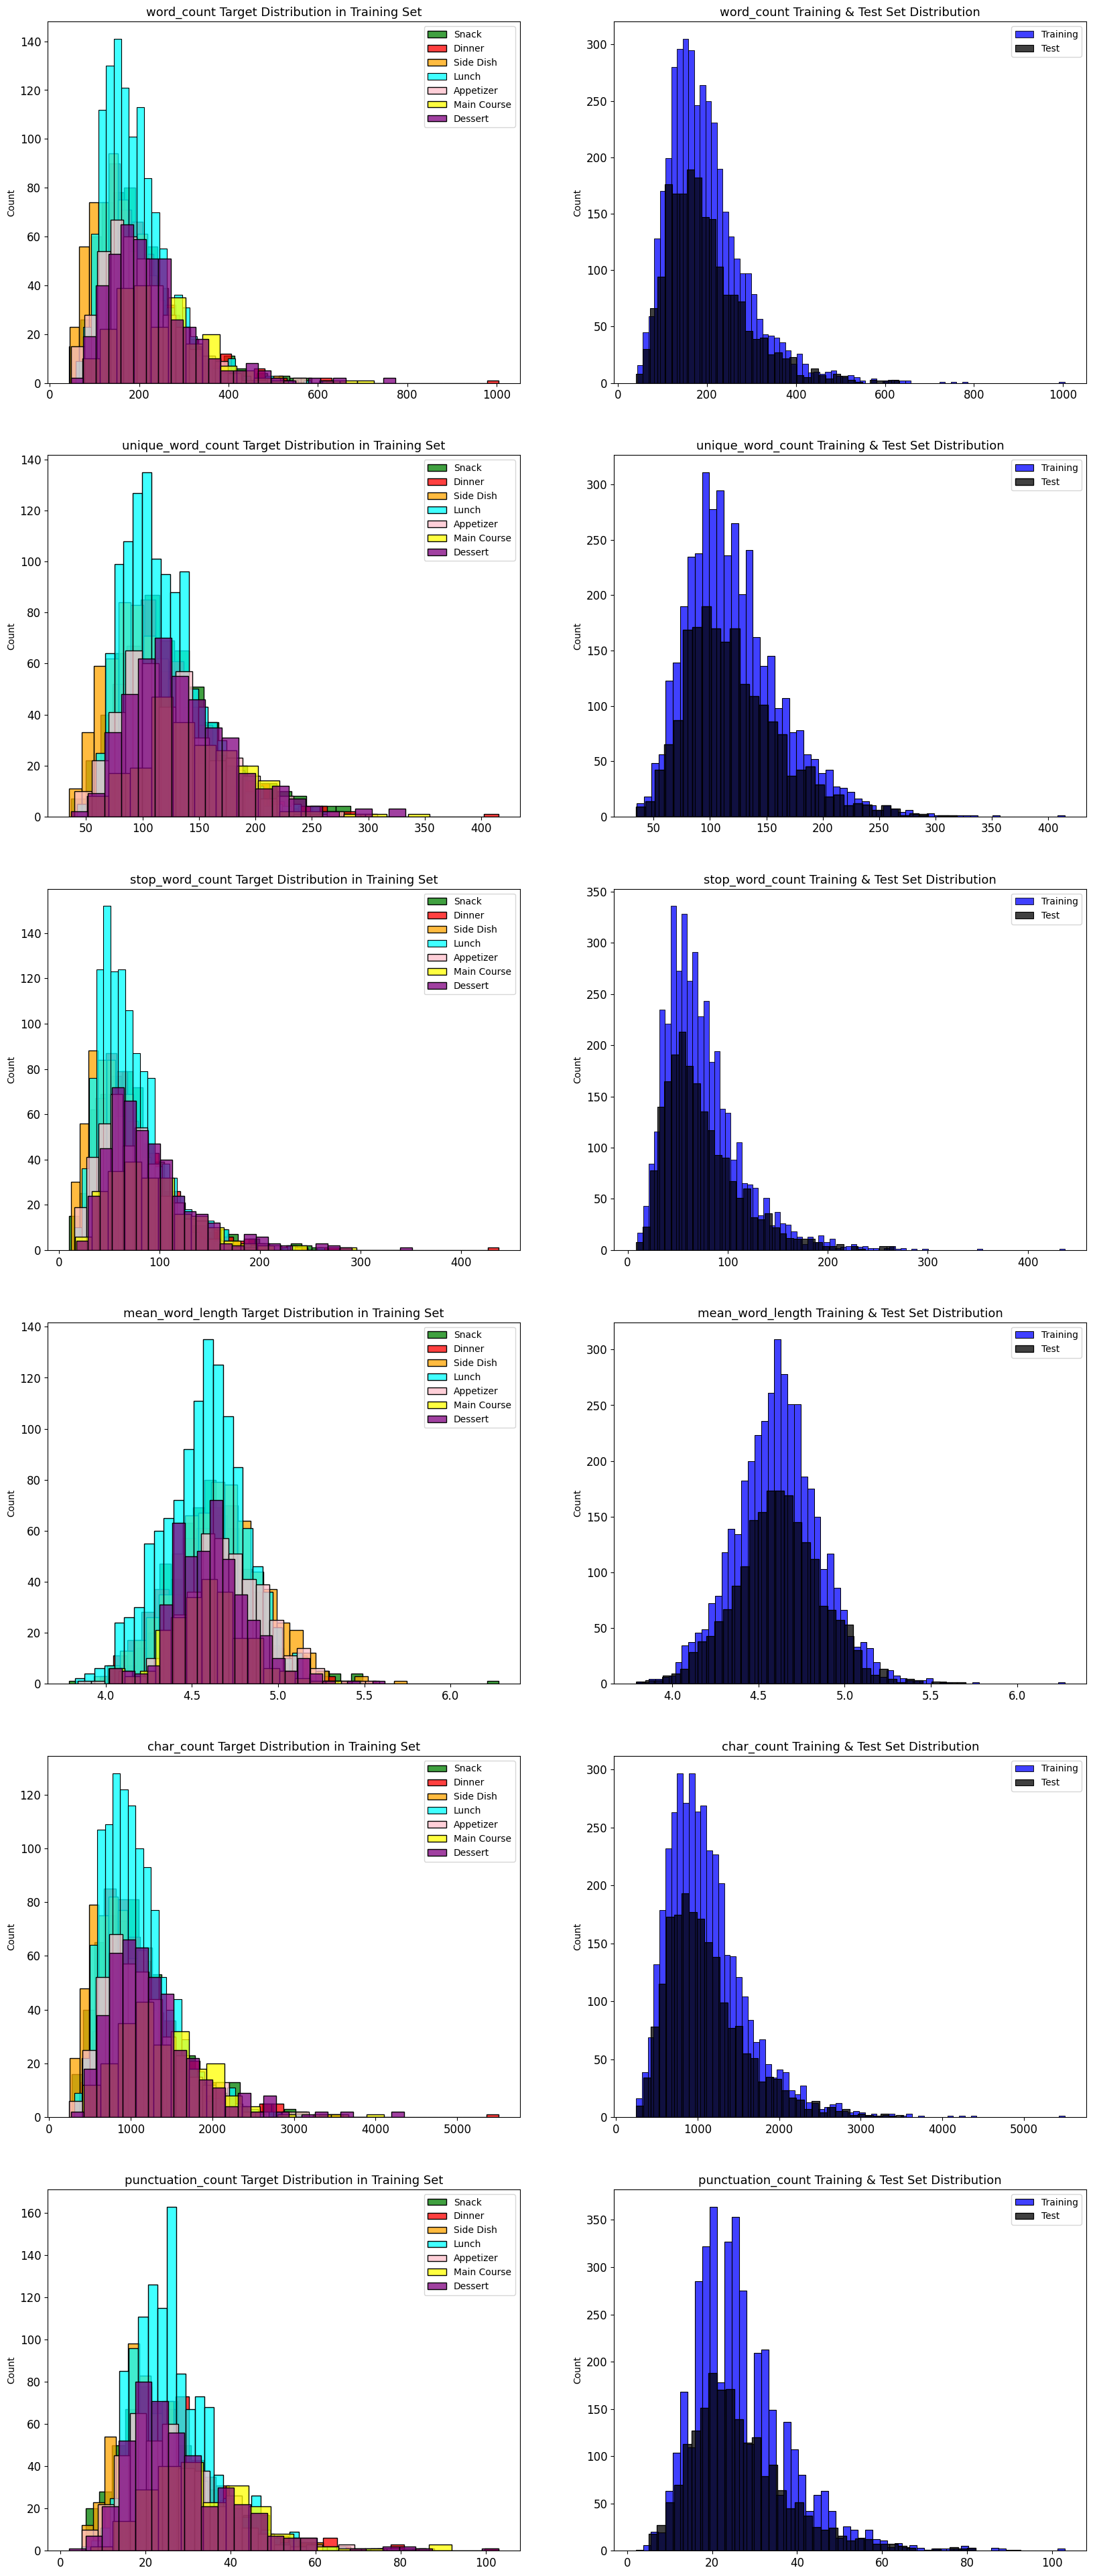

In [13]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count']

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_df.loc[SNACK][feature], label='Snack', ax=axes[i][0], color='green')
    sns.histplot(train_df.loc[DINNER][feature], label='Dinner', ax=axes[i][0], color='red')
    sns.histplot(train_df.loc[SIDEDISH][feature], label='Side Dish', ax=axes[i][0], color='orange')
    sns.histplot(train_df.loc[LUNCH][feature], label='Lunch', ax=axes[i][0], color='cyan')
    sns.histplot(train_df.loc[APPETIZER][feature], label='Appetizer', ax=axes[i][0], color='pink')
    sns.histplot(train_df.loc[MAINCOURSE][feature], label='Main Course', ax=axes[i][0], color='yellow')
    sns.histplot(train_df.loc[DESSERT][feature], label='Dessert', ax=axes[i][0], color='purple')
    
    sns.histplot(train_df[feature], label='Training', ax=axes[i][1], color='blue')
    sns.histplot(test_df[feature], label='Test', ax=axes[i][1],  color='black')
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

All of the meta features have very similar distributions in training and test set which proves that training and test set are taken from the same sample.

All of the meta features have information about `Course` but some of them are not good enough because they have very similar distribution.

`punctuation_count` has slightly different distributions for different Courses. Those features might be useful in models.

## **4. Text Cleaning**

In [14]:
def clean(text):
    # text lowering
    text = text.lower()
    
    # digits to numbers
    after_spliting = re.split("\s+|,", text.strip())
    for index in range(len(after_spliting)):
        if after_spliting[index] in STOPWORDS:
            continue
        if after_spliting[index].isdigit():
            after_spliting[index] = num2words(after_spliting[index])
    text = " ".join(after_spliting)

    # converting any accented characters to ASCII characters
    text = unidecode.unidecode(text)
    
    # expanding contractions
    text = contractions.fix(text)
    
    # Stemming/Lemmatization
    tokens = nltk.word_tokenize(text)
    #     for index in range(len(tokens)):
    # 		# stem word to each word
    #         stem_word = stemmer.stem(tokens[index])
    # 		# update tokens list with stem word
    #         tokens[index] = stem_word
    for index in range(len(tokens)):
        # word to each lemma-word
        lemma_word = lemma.lemmatize(tokens[index])
        # update tokens list with lemma word
        tokens[index] = lemma_word
    text = " ".join(tokens)
    
    # removing and extra spaces
    text = re.sub(pattern=r"\s+", repl=" ", string=text)

    return text

In [15]:
lemma = WordNetLemmatizer()
# stemmer = PorterStemmer()

contractions.add("1/2", "one half")
contractions.add("1/4", "one fourth")
contractions.add("3/4", "three fourth")

tqdm.pandas()
train_df['Instructions_cleaned'] = train_df['TranslatedInstructions'].progress_apply(lambda s : clean(s))
train_df['RecipeName_cleaned'] = train_df['TranslatedRecipeName'].progress_apply(lambda s : clean(s))
train_df['Ingredients_cleaned'] = train_df['TranslatedIngredients'].progress_apply(lambda s : clean(s))

test_df['Instructions_cleaned'] = test_df['TranslatedInstructions'].progress_apply(lambda s : clean(s))
test_df['RecipeName_cleaned'] = test_df['TranslatedRecipeName'].progress_apply(lambda s : clean(s))
test_df['Ingredients_cleaned'] = test_df['TranslatedIngredients'].progress_apply(lambda s : clean(s))

100%|██████████| 1990/1990 [00:07<00:00, 266.04it/s]


## **4. Models**

### **Metric**

* **Accuracy** measures the fraction of the total sample that is correctly identified
* **Precision** measures that out of all the examples predicted as positive, how many are actually positive
* **Recall** measures that out of all the actual positives, how many examples were correctly classified as positive by the model
* **F1 Score** is the harmonic mean of the **Precision** and **Recall**

**Precision**, **Recall** and **F1-Score** are global metrics so they should be calculated on whole training or validation set. `sklearn.metrics.classification_report`, computes those metrics for the given training and validation set.

In [16]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### **4.1 Classical ML**
#### **4.1.2 (Tf-idf) All Features**

In [17]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.Course.values)

In [18]:
xtrain_m, xvalid_m, ytrain_m, yvalid_m = train_test_split(
    train_df[
        [
            "Instructions_cleaned",
            "PrepTimeInMins",
            "CookTimeInMins",
            "TotalTimeInMins",
            "Servings",
        ]
    ].values,
    y,
    stratify=y,
    random_state=42,
    test_size=0.1,
    shuffle=True,
)

xtest_m = test_df[
    [
        "Instructions_cleaned",
        "PrepTimeInMins",
        "CookTimeInMins",
        "TotalTimeInMins",
        "Servings",
    ]
].values
ytest_m = lbl_enc.transform(test_df.Course)

In [19]:
tfv = TfidfVectorizer(
    min_df=2,
    max_features=None,
    analyzer="word",
    token_pattern=r"\w{1,}",
    ngram_range=(1, 3),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words="english",
)

# Fitting TF-IDF to training
tfv.fit(list(xtrain_m[:, 0]))
xtrain_tfv_m = tfv.transform(xtrain_m[:, 0])
xvalid_tfv_m = tfv.transform(xvalid_m[:, 0])
xtest_tfv_m = tfv.transform(xtest_m[:, 0])

xtrain_tfv_m = xtrain_tfv_m.toarray()
xvalid_tfv_m = xvalid_tfv_m.toarray()
xtest_tfv_m = xtest_tfv_m.toarray()

xtrain_tfv_m = np.append(xtrain_tfv_m, xtrain_m[:, 1:].tolist(), 1)
xvalid_tfv_m = np.append(xvalid_tfv_m, xvalid_m[:, 1:].tolist(), 1)
xtest_tfv_m = np.append(xtest_tfv_m, xtest_m[:, 1:].tolist(), 1)

In [20]:
# Apply SVD, I chose 15 components. 10-20 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=15)
svd.fit(xtrain_tfv_m)
xtrain_svd_m = svd.transform(xtrain_tfv_m)
xvalid_svd_m = svd.transform(xvalid_tfv_m)
xtest_svd_m = svd.transform(xtest_tfv_m)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd_m)
xtrain_svd_scl_m = scl.transform(xtrain_svd_m)
xvalid_svd_scl_m = scl.transform(xvalid_svd_m)
xtest_svd_scl_m = scl.transform(xtest_svd_m)

In [21]:
# Fitting a simple SVM
clf = SVC(C=0.55, probability=True)
clf.fit(xtrain_svd_scl_m, ytrain_m)
predictions = clf.predict_proba(xvalid_svd_scl_m)

print ("logloss: %0.3f " % multiclass_logloss(yvalid_m, predictions))
print(f"Training Acc:{clf.score(xtrain_svd_scl_m, ytrain_m)}, Validation Acc:{clf.score(xvalid_svd_scl_m, yvalid_m)}")

logloss: 1.105 
Training Acc:0.6018161805173363, Validation Acc:0.594059405940594


In [22]:
predictions = clf.predict_proba(xtest_svd_scl_m)
print(metrics.classification_report(ytest_m, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.52      0.49      0.50       228
     Dessert       0.81      0.84      0.83       209
      Dinner       0.52      0.22      0.31       274
       Lunch       0.56      0.88      0.68       569
 Main Course       0.57      0.23      0.33        92
   Side Dish       0.66      0.41      0.50       339
       Snack       0.63      0.68      0.66       279

    accuracy                           0.60      1990
   macro avg       0.61      0.53      0.54      1990
weighted avg       0.60      0.60      0.57      1990



### **4.1.3 (Tf-idf) Using Instructions**

In [23]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train_df.Instructions_cleaned.values,
    y,
    stratify=y,
    random_state=42,
    test_size=0.1,
    shuffle=True,
)

xtest = test_df[["Instructions_cleaned"]].values.reshape(-1)
ytest = lbl_enc.transform(test_df.Course)

In [24]:
tfv = TfidfVectorizer(min_df=2,  max_features=None, analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(xtrain))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [25]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
clf.score(xtrain_tfv, ytrain), clf.score(xvalid_tfv, yvalid)

logloss: 2.033 


(0.530820033021464, 0.4207920792079208)

In [26]:
predictions = clf.predict_proba(xtest_tfv)
print(metrics.classification_report(ytest, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.77      0.04      0.08       228
     Dessert       0.88      0.49      0.63       209
      Dinner       0.75      0.02      0.04       274
       Lunch       0.35      0.98      0.52       569
 Main Course       0.00      0.00      0.00        92
   Side Dish       0.73      0.02      0.05       339
       Snack       0.54      0.49      0.51       279

    accuracy                           0.41      1990
   macro avg       0.57      0.29      0.26      1990
weighted avg       0.58      0.41      0.31      1990



In [27]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=12)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [28]:
# Fitting a simple SVM
clf = SVC(C=0.55, probability=True)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(clf.score(xtrain_svd_scl, ytrain), clf.score(xvalid_svd_scl, yvalid))

logloss: 1.110 
0.6012658227848101 0.5866336633663366


In [29]:
predictions = clf.predict_proba(xtest_svd_scl)
print(metrics.classification_report(ytest, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.50      0.46      0.48       228
     Dessert       0.79      0.85      0.82       209
      Dinner       0.49      0.22      0.30       274
       Lunch       0.54      0.88      0.67       569
 Main Course       0.52      0.16      0.25        92
   Side Dish       0.68      0.36      0.47       339
       Snack       0.63      0.66      0.65       279

    accuracy                           0.59      1990
   macro avg       0.59      0.51      0.52      1990
weighted avg       0.59      0.59      0.56      1990



In [30]:
eval_set = [(xtrain_svd_scl, ytrain), (xvalid_svd_scl, yvalid)]
clf = xgb.XGBClassifier(max_depth=2, n_estimators=300, colsample_bytree=0.9,
                        subsample=0.5, learning_rate=0.05, use_label_encoder=False, 
                        tree_method='gpu_hist', gpu_id=0, reg_lambda=1e-4)
clf.fit(xtrain_svd_scl, ytrain, eval_set=eval_set, early_stopping_rounds=4, eval_metric=["mlogloss"], verbose=False)
predictions = clf.predict_proba(xvalid_svd_scl)

results = clf.evals_result()

print (f"logloss: {multiclass_logloss(yvalid, predictions)}, epochs: {len(results['validation_0']['mlogloss'])}")
print(clf.score(xtrain_svd_scl, ytrain), clf.score(xvalid_svd_scl, yvalid))

logloss: 1.1713191699513261, epochs: 223
0.6235553109521189 0.5742574257425742


In [31]:
predictions = clf.predict_proba(xtest_svd_scl)
print(metrics.classification_report(ytest, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.47      0.46      0.47       228
     Dessert       0.82      0.81      0.81       209
      Dinner       0.46      0.22      0.30       274
       Lunch       0.54      0.85      0.66       569
 Main Course       0.39      0.16      0.23        92
   Side Dish       0.69      0.36      0.47       339
       Snack       0.60      0.70      0.64       279

    accuracy                           0.58      1990
   macro avg       0.57      0.51      0.51      1990
weighted avg       0.58      0.58      0.55      1990



### **4.1.4 Word2Vec**

In [32]:
instructions_vec = [nltk.word_tokenize(instruction) for instruction in train_df.Instructions_cleaned.values]
instructions_test_vec = [nltk.word_tokenize(instruction) for instruction in test_df.Instructions_cleaned.values]
model = Word2Vec(instructions_vec, sg=1, vector_size=300, window=15, min_count=1, workers=4)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [33]:
# this function creates a normalized vector for the whole sentence
def sent2vec_with_w2v(s):
    words = nltk.word_tokenize(s)
    M = []
    for w in words:
        try:
            M.append(w2v[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [34]:
xtrain_w2v = np.array([sent2vec_with_w2v(x) for x in xtrain])
xvalid_w2v = np.array([sent2vec_with_w2v(x) for x in xvalid])
xtest_w2v = np.array([sent2vec_with_w2v(x) for x in xtest])

In [35]:
# Apply SVD, I chose 30 components. 20-40 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=30)
svd.fit(xtrain_w2v)
xtrain_svd = svd.transform(xtrain_w2v)
xvalid_svd = svd.transform(xvalid_w2v)
xtest_svd = svd.transform(xtest_w2v)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [36]:
# Fitting a simple SVM
clf = SVC(C=0.55, degree=1, kernel="rbf", probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
print(clf.score(xtrain_svd_scl, ytrain), clf.score(xvalid_svd_scl, yvalid))

logloss: 1.046 
0.6986791414419372 0.6138613861386139


In [37]:
predictions = clf.predict_proba(xtest_svd_scl)
print(metrics.classification_report(ytest, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.56      0.54      0.55       228
     Dessert       0.83      0.85      0.84       209
      Dinner       0.54      0.23      0.32       274
       Lunch       0.56      0.87      0.68       569
 Main Course       0.47      0.23      0.31        92
   Side Dish       0.67      0.44      0.53       339
       Snack       0.68      0.72      0.70       279

    accuracy                           0.62      1990
   macro avg       0.62      0.55      0.56      1990
weighted avg       0.62      0.62      0.59      1990



In [38]:
eval_set = [(xtrain_svd_scl, ytrain), (xvalid_svd_scl, yvalid)]
clf = xgb.XGBClassifier(max_depth=2, n_estimators=100, colsample_bytree=0.8,
                        subsample=0.2, learning_rate=0.2, use_label_encoder=False, 
                        tree_method='gpu_hist', gpu_id=0, reg_lambda=1e-5)
clf.fit(xtrain_svd_scl, ytrain, eval_set=eval_set, early_stopping_rounds=10, eval_metric=["mlogloss"], verbose=False)
predictions = clf.predict_proba(xvalid_svd_scl)

results = clf.evals_result()

print (f"logloss: {multiclass_logloss(yvalid, predictions)}, epochs: {len(results['validation_0']['mlogloss'])}")
print(clf.score(xtrain_svd_scl, ytrain), clf.score(xvalid_svd_scl, yvalid))

logloss: 1.1987302799635373, epochs: 66
0.6496973032471106 0.5767326732673267


In [39]:
predictions = clf.predict_proba(xtest_svd_scl)
print(metrics.classification_report(ytest, np.argmax(predictions, axis=1), target_names=lbl_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])))

              precision    recall  f1-score   support

   Appetizer       0.52      0.44      0.48       228
     Dessert       0.77      0.81      0.79       209
      Dinner       0.41      0.22      0.29       274
       Lunch       0.52      0.84      0.64       569
 Main Course       0.42      0.14      0.21        92
   Side Dish       0.60      0.34      0.44       339
       Snack       0.64      0.66      0.65       279

    accuracy                           0.56      1990
   macro avg       0.55      0.49      0.50      1990
weighted avg       0.56      0.56      0.54      1990



In [40]:
# fig, ax = plt.subplots()

# epochs = len(results['validation_0']['mlogloss'])
# x_axis = range(0, epochs)

# ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()

## **4.2 Deep Learning Models**

## **4.2.1 DistilBert**

In [41]:
MODEL_CLASSES = {
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [42]:
# Parameters
use_fp16 = False
bs = 32

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

In [43]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [44]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad', 'distilbert-base-cased', 'distilbert-base-cased-distilled-squad', 'distilbert-base-german-cased', 'distilbert-base-multilingual-cased', 'distilbert-base-uncased-finetuned-sst-2-english'])

In [45]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [46]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [47]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [48]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [49]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [50]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

In [51]:
databunch = (TextList.from_df(train_df, cols=['Instructions_cleaned'], processor=transformer_processor)
             .split_by_rand_pct(0.1, seed=seed)
             .label_from_df(cols='Course')
             .add_test(test_df)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [52]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
[CLS] to begin making the pr ##aw ##n mas ##ala ko ##zh ##uka ##tta ##i recipe - pr ##aw ##n mas ##ala dump ##ling prep all the ingredient and keep them ready . heat oil in a heavy bottom ##ed pan over medium heat . add the mustard seed dry red chill ##i ( broken ) curry leaf and allow it to crack ##le . add the ginger garlic and,Appetizer
[CLS] to begin making the vegetable tar ##tle ##t first for the crust pre ##hea ##t the oven to one hundred and ninety degree ce ##lc ##ius . to make the tar ##tle ##t crust add maid ##a and butter in a mixing bowl or the bowl of a food processor . rub with your finger ##tip till the mixture resembles bread ##cr ##umb ( or pulse 2 - 3,Dinner
[CLS] to begin making the ga ##jar hal ##wa shot make the bas ##und ##i ( ra ##bri ) recipe ( a nut ##ty condensed milk pudding ) and easy ga ##jar hal ##wa recipe with k ##ho ##ya made in a pressure cooke ##r before hand and keep it ready . * for the bas ##und ##i / ra ##bri to begin making the bas ##und ##i recipe we,Dessert
[CLS] to begin making the chicken ke ##ema sam ##osa recipe place the flour g ##hee salt and aj ##wai ##n in the food processor . add little water at a time and make a firm and yet smooth dough . divide the dough into large lemon size portion . cover the dough and keep aside . in the same food processor jar attach the chopper blade . add the,Appetizer
[CLS] to begin making the creamy mushroom mini pie recipe get all the ingredient ready and make the pie crust according to the ` ` short crust tar ##t pastry dough ' ' recipe . ref ##ri ##ger ##ate the pie dough for a couple of hours . while the pie dough is ref ##ri ##ger ##ating we will proceed to make the mushroom pie filling . to make the,Snack


In [53]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([32, 512])
tensor([[  101,  2000,  4088,  ..., 14192,  6090,   102],
        [  101,  2000,  4088,  ...,  1996,  3514,   102],
        [  101,  2000,  4088,  ...,  3089,  4590,   102],
        ...,
        [  101,  2000,  4088,  ...,  2633,  5435,   102],
        [  101,  2000,  4088,  ...,  3684,  1037,   102],
        [  101,  2000,  4088,  ..., 16020,  2063,   102]])


In [54]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        return logits

In [55]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 7
config.use_bfloat16 = use_fp16
# print(config)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

In [56]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 7)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [57]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [58]:
learner_dict = {0:'Appetizer', 1:'Dessert', 2:'Dinner', 3:'Lunch', 4:'Main Course', 5:'Side Dish', 6:'Snack'}

In [59]:
# print(learner.model)

In [60]:
# For DistilBERT
list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0],
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]

In [61]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 8 groups


In [62]:
learner.freeze_to(-1)

In [63]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-04
Min loss divided by 10: 2.51E-04


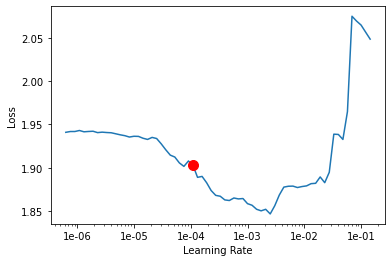

In [64]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.736270,1.709340,0.337469,0.662531,00:22


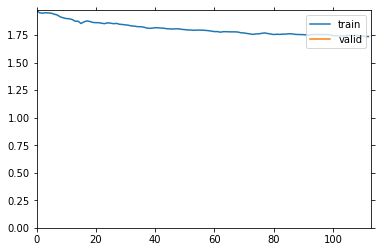

In [65]:
learner.fit_one_cycle(1, max_lr=1e-4, moms=(0.8,0.7))

In [66]:
learner.freeze_to(-2)

In [67]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.498234,1.425227,0.451613,0.548387,00:27


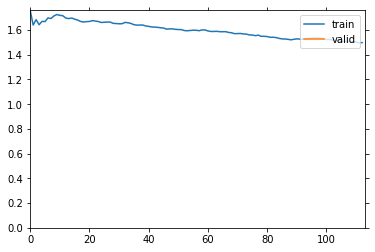

In [68]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [69]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.262849,1.199144,0.540943,0.459057,00:32


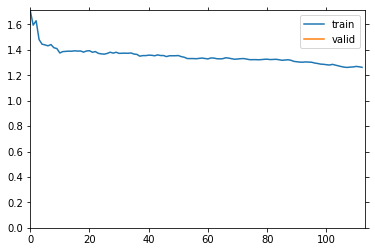

In [70]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [71]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.165405,1.128007,0.578164,0.421836,00:52
1,1.039172,1.003733,0.625310,0.374690,00:55
2,0.918799,0.990678,0.642680,0.357320,00:52
3,0.790467,0.969680,0.652605,0.347395,00:53
4,0.731126,0.964021,0.662531,0.337469,00:53


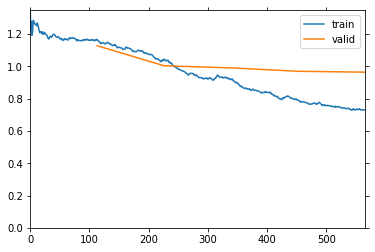

In [72]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [73]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [74]:
test_preds = get_preds_as_nparray(DatasetType.Test)
print(metrics.classification_report(np.vectorize(learner_dict.get)(np.argmax(test_preds, axis=1)).astype('object'), test_df.Course.to_numpy()))

              precision    recall  f1-score   support

   Appetizer       0.64      0.63      0.63       230
     Dessert       0.95      0.75      0.84       266
      Dinner       0.31      0.54      0.40       158
       Lunch       0.64      0.60      0.62       602
 Main Course       0.50      0.16      0.25       281
   Side Dish       0.42      0.69      0.53       208
       Snack       0.67      0.76      0.71       245

    accuracy                           0.59      1990
   macro avg       0.59      0.59      0.57      1990
weighted avg       0.62      0.59      0.58      1990



## **4.2.2 RoBerta**

In [75]:
# Parameters
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

In [76]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [77]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [78]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [79]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [80]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [81]:
databunch = (TextList.from_df(train_df, cols=['Instructions_cleaned'], processor=transformer_processor)
             .split_by_rand_pct(0.1, seed=seed)
             .label_from_df(cols='Course')
             .add_test(test_df)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [82]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġto Ġbegin Ġmaking Ġthe Ġegg less Ġor Ġvegan Ġchrist mas Ġcake Ġrecipe Ġwe Ġfirst Ġhave Ġto Ġsoak Ġall Ġthe Ġdry Ġfruit Ġin Ġrum Ġand Ġjuice Ġ( Ġyou Ġcan Ġavoid Ġthe Ġrum Ġ) Ġ. Ġthis Ġprocess Ġhelp Ġferment Ġthe Ġfruit Ġand Ġalso Ġhelp Ġto Ġrelease Ġall Ġthe Ġflavor Ġand Ġmake Ġthe Ġchrist mas Ġcake Ġmoist Ġand Ġrich . place Ġthe Ġs ult ana Ġdried Ġpr une Ġdried Ġdate Ġdried Ġfig,Dessert
<s> Ġto Ġbegin Ġmaking Ġthe Ġg aj ar Ġhal wa Ġshot Ġmake Ġthe Ġbas und i Ġ( Ġrab ri Ġ) Ġrecipe Ġ( Ġa Ġnut ty Ġcondensed Ġmilk Ġpudding Ġ) Ġand Ġeasy Ġg aj ar Ġhal wa Ġrecipe Ġwith Ġkh oya Ġmade Ġin Ġa Ġpressure Ġcooker Ġbefore Ġhand Ġand Ġkeep Ġit Ġready Ġ. Ġ* for Ġthe Ġbas und i / rab ri Ġto Ġbegin Ġmaking Ġthe Ġbas und i Ġrecipe Ġwe,Dessert
<s> Ġto Ġbegin Ġmaking Ġthe Ġchicken Ġke ema Ġsam osa Ġrecipe Ġplace Ġthe Ġflour Ġg hee Ġsalt Ġand Ġa j w ain Ġin Ġthe Ġfood Ġprocessor Ġ. Ġadd Ġlittle Ġwater Ġat Ġa Ġtime Ġand Ġmake Ġa Ġfirm Ġand Ġyet Ġsmooth Ġdough . div ide Ġthe Ġdough Ġinto Ġlarge Ġlemon Ġsize Ġportion Ġ. Ġcover Ġthe Ġdough Ġand Ġkeep Ġaside . in Ġthe Ġsame Ġfood Ġprocessor Ġjar Ġattach Ġthe Ġcho pper Ġblade,Appetizer
<s> Ġto Ġbegin Ġmaking Ġthe Ġtart Ġproven cal Ġmade Ġwith Ġrat at ou ille Ġstart Ġpre pping Ġwith Ġall Ġthe Ġingredient Ġand Ġchop Ġthe Ġve ggie Ġand Ġmake Ġthe Ġtart Ġcrust Ġto Ġstart . for Ġthe Ġcrust pre - heat Ġthe Ġoven Ġto Ġone Ġhundred Ġand Ġninety Ġdegree Ġc elsius . add Ġmaid a Ġand Ġbutter Ġin Ġa Ġmixing Ġbowl Ġor Ġthe Ġbowl Ġof Ġa Ġfood Ġprocessor . rub Ġwith,Lunch
<s> Ġto Ġbegin Ġmaking Ġmushroom Ġt ik ka Ġmas ala Ġrecipe Ġ( Ġmushroom Ġ& Ġbell Ġpepper Ġin Ġspicy Ġtomato Ġgravy Ġ) Ġprep Ġup Ġwith Ġall Ġthe Ġingredient Ġand Ġstart Ġwith Ġmar inating Ġthe Ġmushrooms . in Ġa Ġlarge Ġmixing Ġbowl Ġadd Ġall Ġthe Ġmar in ade Ġingredient Ġexcept Ġmushrooms . mix Ġwell Ġdo Ġa Ġtaste Ġtest Ġand Ġadjust Ġspice Ġand Ġsalt Ġaccording Ġto Ġyour Ġtaste . add Ġin Ġthe Ġcut,Side Dish


In [83]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 7
config.use_bfloat16 = use_fp16

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [84]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 7)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [85]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [86]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [87]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, 'groups')
# print(learner.layer_groups)

Learner split in 14 groups


In [88]:
learner.freeze_to(-1)

In [89]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.45E-04


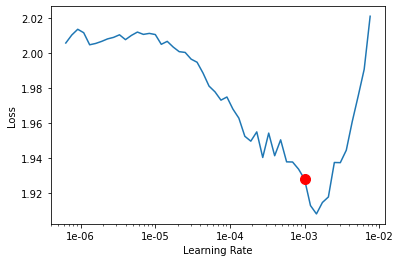

In [90]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.803355,1.787295,0.277916,0.722084,00:41


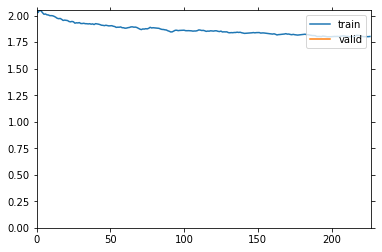

In [91]:
learner.fit_one_cycle(1, max_lr=1e-4, moms=(0.8,0.7))

In [92]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.247222,1.123437,0.578164,0.421836,00:51


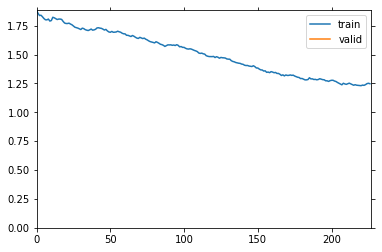

In [93]:
learner.fit_one_cycle(1, max_lr=1e-4, moms=(0.8,0.7))

In [94]:
learner.freeze_to(-3)

In [95]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.094588,1.083320,0.578164,0.421836,00:52


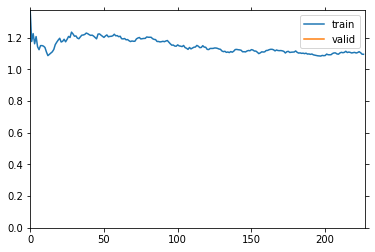

In [96]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [97]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.110913,1.087095,0.585608,0.414392,01:54
1,1.007743,1.022735,0.583127,0.416873,01:46
2,0.864571,0.978393,0.637717,0.362283,01:53
3,0.782810,0.977579,0.645161,0.354839,01:58


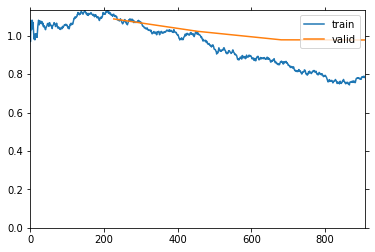

In [98]:
learner.fit_one_cycle(4, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [99]:
test_preds = get_preds_as_nparray(DatasetType.Test)
print(metrics.classification_report(np.vectorize(learner_dict.get)(np.argmax(test_preds, axis=1)).astype('object'), test_df.Course.to_numpy()))

              precision    recall  f1-score   support

   Appetizer       0.57      0.54      0.56       244
     Dessert       0.90      0.86      0.88       219
      Dinner       0.28      0.43      0.34       182
       Lunch       0.69      0.60      0.64       645
 Main Course       0.15      0.36      0.21        39
   Side Dish       0.62      0.49      0.55       430
       Snack       0.62      0.75      0.68       231

    accuracy                           0.60      1990
   macro avg       0.55      0.58      0.55      1990
weighted avg       0.63      0.60      0.61      1990



## **5. Predictive Analysis**

In [100]:
predictions = np.vectorize(learner_dict.get)(np.argmax(test_preds, axis=1)).astype('object')
ys = test_df.Course.to_numpy()

In [101]:
test_df["predictions"] = predictions
index_inc_pred = np.where((predictions != ys) == True)[0]

In [102]:
inc_pred_dfs = test_df[["TranslatedInstructions", "Course", "predictions"]].loc[index_inc_pred]
inc_pred_dfs.to_csv("/kaggle/working/preds.csv", index=False);

In [103]:
inc_pred_dfs.reset_index(drop=True, inplace=True)

In [104]:
inc_pred_dfs

,TranslatedInstructions,Course,predictions
0,"To begin making the Haleem Ke Kebab Recipe, in...",Appetizer,Side Dish
1,To prepare Broccoli Bell Pepper Cheese Quesadi...,Lunch,Appetizer
2,To begin making the Konkani Style Vali Bendi R...,Side Dish,Lunch
3,"To begin making the Chicken Tikka Masala, thor...",Lunch,Dinner
4,"To begin making Beetroot, Sweet Potato and Oat...",Appetizer,Snack
...,...,...,...
799,To begin making the Chettinad Mutton Chops Kuz...,Lunch,Side Dish
800,To begin making the Karwar Style Kelya Sasav R...,Snack,Side Dish
801,"To begin making green moong ki sabzi, firstly ...",Side Dish,Lunch
802,To begin making the Kale Chane Ki Kadhi Recipe...,Dinner,Lunch


In [105]:
print(inc_pred_dfs.iloc[3].TranslatedInstructions)
print(inc_pred_dfs.iloc[3].Course)
print(inc_pred_dfs.iloc[3].predictions)

To begin making the Chicken Tikka Masala, thoroughly clean and wash the chicken pieces. To marinate the Chicken for the Chicken Tikka Masala, in a mixing bowl, combine yogurt, cumin powder, coriander powder, turmeric powder, ginger, garlic, chili powder, kasuri methi and salt along with the chicken. Allow the chicken to marinate for a minimum of 30 minutes. Once the chicken is marinated, in a pan, add a teaspoon of oil and cook marinated chicken pieces until they are cooked well for about 8 minutes. The chicken pieces should be juicy and tender.Cooking chicken for an extended time will make them hard and rubbery. Do not add water.The next step is to make the tikka masala gravy. Heat a teaspoon of oil over medium heat. Add onion and cook until they become translucent. Add tomatoes and cook them for about two minutes. Add cashews and toss them for a minute. Allow the onion tomato masala to cool down.Once it cools down, grind onion, tomato, and cashew into a fine paste.Heat a kadai/wok wi

In [106]:
learner.predict(clean(inc_pred_dfs.iloc[3].TranslatedInstructions))

(Category Side Dish,
 tensor(5),
 tensor([1.3936e-02, 1.2785e-04, 2.6392e-01, 2.0880e-01, 2.0388e-01, 3.0923e-01,
         1.0462e-04]))

In [107]:
learner_dict

{0: 'Appetizer',
 1: 'Dessert',
 2: 'Dinner',
 3: 'Lunch',
 4: 'Main Course',
 5: 'Side Dish',
 6: 'Snack'}

#### **Observations**

- From this instruction for making `Chicken Tikka Masala`, it is inferenced that this meal belongs to `Dinner` Course as per the instructions given.
- But as we all know `Chicken Tikka Masala` can be considered for `Dinner`, `Lunch`, `Main Course` as well as `Side Dish`.
- From the above code, we checked the class probabilty for different `Courses`, and noticed that the model (Roberta) is uncertain whether it should be `2, 3, 4, or 5 classes` which are the codes for `Dinner`, `Lunch`, `Main Course` & `Side Dish`.

> Let's check if this is the case for other meals as well.

In [108]:
preds = []
for index, row in inc_pred_dfs.iterrows():
    preds.append(learner.predict(clean(row.TranslatedInstructions))[2])

In [109]:
torch.set_printoptions(linewidth=100)

In [110]:
torch.stack(preds)[0:10, :]

tensor([[8.8398e-01, 6.0092e-05, 5.9310e-03, 2.2042e-03, 5.5582e-03, 7.7834e-02, 2.4437e-02],
        [5.3004e-01, 1.8450e-04, 1.3755e-01, 4.8238e-02, 2.2113e-02, 2.3040e-01, 3.1476e-02],
        [1.7215e-03, 7.3632e-05, 4.0946e-02, 6.8606e-01, 8.4136e-02, 1.8674e-01, 3.2685e-04],
        [1.3936e-02, 1.2785e-04, 2.6392e-01, 2.0880e-01, 2.0388e-01, 3.0923e-01, 1.0462e-04],
        [6.0890e-02, 4.4942e-03, 2.5265e-04, 4.2744e-04, 1.2701e-04, 6.4866e-03, 9.2732e-01],
        [3.7778e-03, 8.5179e-05, 1.2504e-01, 4.3341e-01, 1.2056e-01, 3.1706e-01, 7.3538e-05],
        [1.1363e-01, 3.6235e-04, 4.2749e-02, 4.9589e-01, 3.4192e-02, 2.9299e-01, 2.0180e-02],
        [6.0267e-02, 5.3415e-03, 7.3358e-04, 1.6548e-03, 2.7774e-04, 8.6667e-02, 8.4506e-01],
        [5.1324e-01, 9.5350e-04, 1.3897e-02, 3.6355e-03, 1.2055e-03, 3.9326e-01, 7.3808e-02],
        [4.8201e-03, 2.3264e-05, 3.3697e-01, 3.7869e-01, 2.7747e-02, 2.5162e-01, 1.2769e-04]])

#### **Inference**

An interpretation can also be drawn from the probabilty distribution of incorrectly predicted type of `Course`, that most of these probabilty vectors have very similar probabilties for classes `2, 3, 4, & 5` which correspond to `Dinner`, `Lunch`, `Main Course` & `Side Dish` Courses.

## **6. Conclusion(s)**

* #### The 6000 Indian Food Recipes Dataset is a collection of various food recipes in India. I was given a task to create a model for `Course` prediction from Instruction of the recipes along with other meta-data like Ingredients, cooking time, etc.

* #### In this NoteBook, I worked on a model to map this relationship as a function (ML/DL model). I applied various classsic word embedding models such as Tf-idf, word2vec and then used multiple classifiers on top of these features to find the best `Course` type.

* #### Since transformer models are such widely used in NLP tasks, I created (Distil Bert, Roberta) transformer models with the help of transformers library along with fastai library.

* #### After building these models, I also did some predictive analysis based on the predictions produced by Roberta-transformer model and found out that a lot miss-classifications are because of poor data quality. As I found out that a lot of these dishes can and are offered in multple `Courses` and the model is also confused between the possible outcomes as we saw in the previous section.

* #### Finally, my opnion is that to get the best results for the problem that we are trying to solve i.e. `Course` Prediction, we need to first transform the data into a multi-labelled dataset, and then create a model that handle that data and predict the precise `Courses` (multiple if required) that a dish can be offered at.

## **EOF**